In [2]:
import numpy as np
import pandas as pd
import pickle
import os

from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.ndimage.filters import uniform_filter1d
from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

/var/folders/py/bm4kf8_j7tn54t9vvg2pyb5r0000gn/T/ipykernel_41197/2085468766.py:11: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


## Load Data

In [3]:
# # Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# For Google Colab
TrainSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TrainData.pickle"
TestSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/TestData.pickle"

FileSource = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/allData.pickle"
ScalerPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/Scaler.pickle"
ModelPath = "/content/drive/MyDrive/StrangeLandDataAnalysis/GeneratedData/Model.pickle"

In [5]:
# For Local
TrainSource = "./GeneratedData/TrainData.pickle"
TestSource = "./GeneratedData/TestData.pickle"

FileSource = "./GeneratedData/allData.pickle"
ScalerPath = "./GeneratedData/Scaler.pickle"
ModelPath = "./GeneratedData/Model.pickle"

In [6]:
FileList=[]
with open(FileSource,'rb') as f:
    FileList = pickle.load(f)

In [7]:
InputHeader = ["ApproachRateOther",
                "Rel_Pos_Magnitude",
                "SteerB",
                "A_Head_Center_Distance", "B_Head_Center_Distance",
                "Filtered_B_Head_Velocity_Total",
                "A_Turn",
                "B_Indicator",
                "Centerline_Offset_B",
                "RelativeRotation"] # Signaling ()

OutputHeader = ["AccelA", "Centerline_Offset_A"]

In [8]:
InputHeader_AB = ["ApproachRateOther", 
                  "Rel_Pos_Magnitude", 
                  "RelativeRotation"] # Signaling ()
InputHeader_A = ["A_Head_Center_Distance", 
                 "A_Turn"]
InputHeader_B = ["SteerB", 
                 "B_Head_Center_Distance",
                 "Filtered_B_Head_Velocity_Total",
                 "B_Indicator",
                 "Centerline_Offset_B"]

OutputHeader_A = ["AccelA", "Centerline_Offset_A"]
OutputHeader_B = ["AccelB", "Centerline_Offset_B"]

## Polynomial Model

### Lag Plot for targets

In [9]:
# Function to smooth data
def smooth_data(data, window_size=5):
    return uniform_filter1d(data, size=window_size)

# Define a function to create lag plots with smoothed lines
def lag_plot_with_smooth(data, target_col, max_lag=4, window_size=5):
    plt.figure(figsize=(14, 10))
    for lag in range(1, max_lag + 1):
        plt.subplot(2, 2, lag)
        lagged_data = data[target_col].shift(lag)
        
        # Drop NaNs and ensure both series have the same length
        valid_idx = ~lagged_data.isna() & ~data[target_col].isna()
        lagged_data = lagged_data[valid_idx]
        target_data = data[target_col][valid_idx]

        sns.scatterplot(x=lagged_data, y=target_data, alpha=0.5)
        
        # Smooth data
        smoothed_x = smooth_data(np.sort(lagged_data.values), window_size)
        smoothed_y = smooth_data(np.sort(target_data.values), window_size)
        
        # Plot smoothed line
        plt.plot(smoothed_x, smoothed_y, color='red')
        
        plt.xlabel(f'{target_col} (t-{lag})')
        plt.ylabel(f'{target_col} (t)')
        plt.title(f'Lag {lag}')
    plt.tight_layout()
    plt.show()


In [10]:
# Concatenate all data
data_frames = []

for file_path in FileList:
    if not os.path.exists(file_path):
        print(f"Could not find {file_path}")
        continue
    data = pd.read_feather(file_path)
    data_frames.append(data)

data = pd.concat(data_frames, ignore_index=True)

In [11]:
# Plot only one time series of data
data = data = pd.read_feather(FileList[0])

/Users/zhuoqi/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


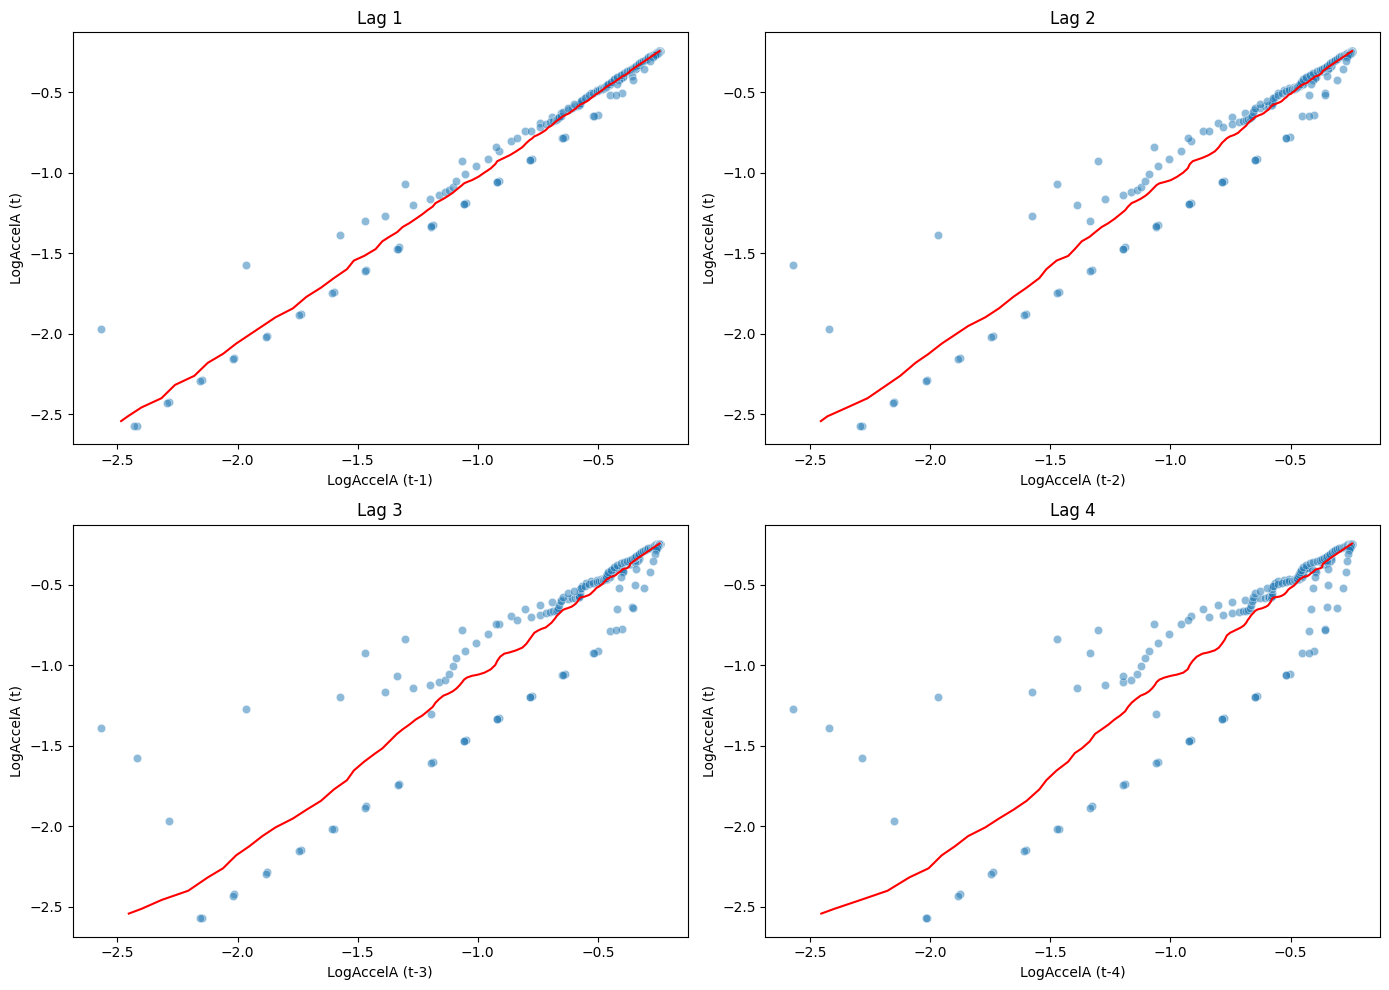

In [12]:
# Take the logarithm of the target variable (AccelA)
data['LogAccelA'] = np.log10(data['AccelA'].replace(0, np.nan)).dropna()

# Create lag plots for the log-transformed AccelA
lag_plot_with_smooth(data, 'LogAccelA')

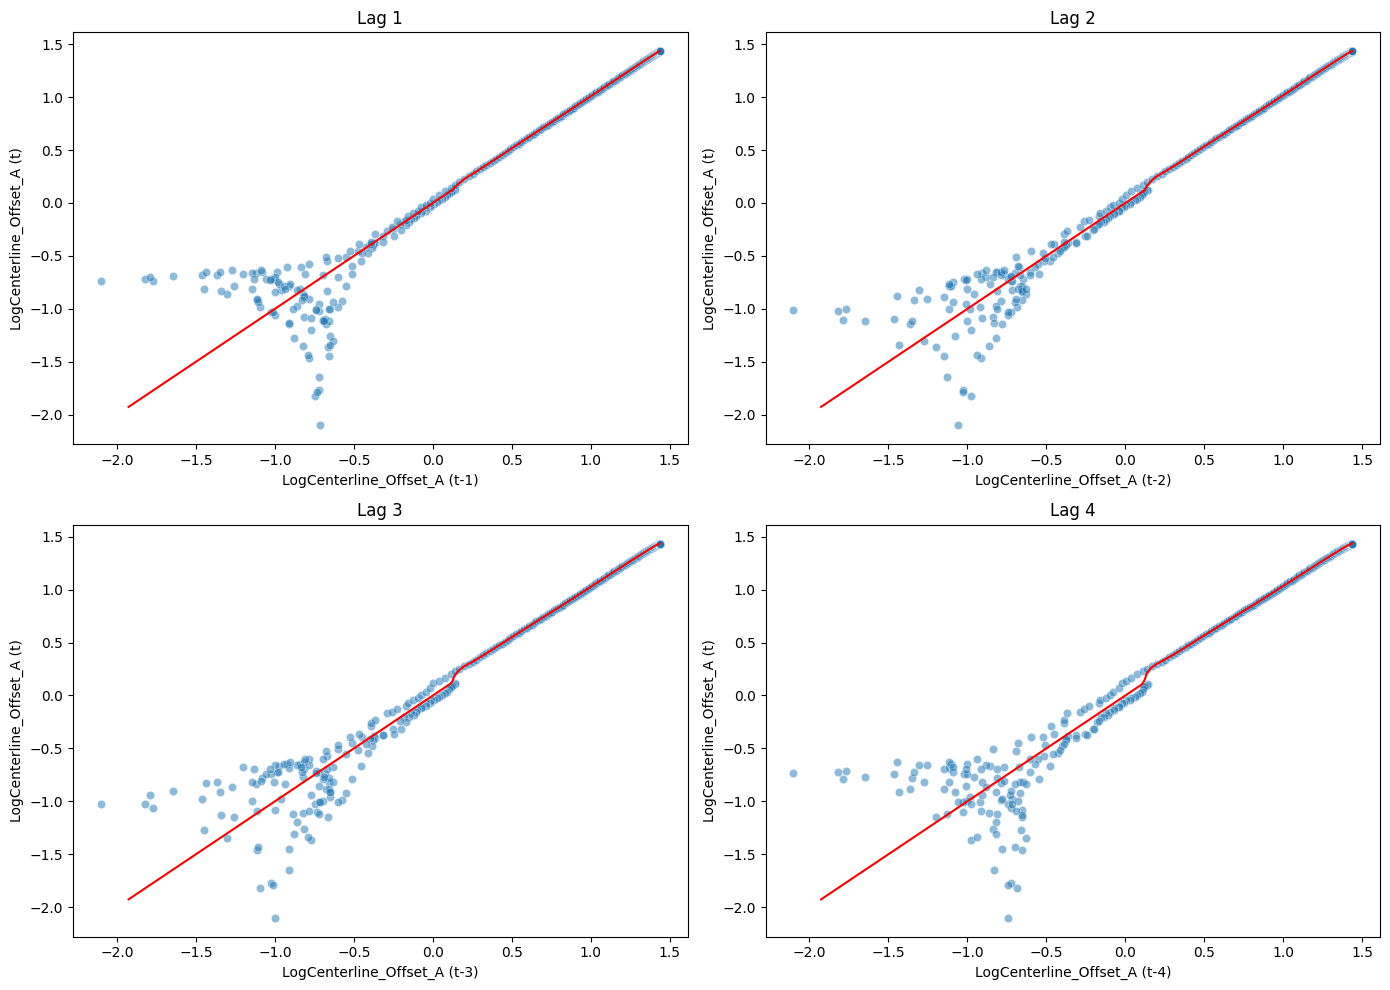

In [13]:
# Take the logarithm of the target variable (Centerline_Offset_A)
data['LogCenterline_Offset_A'] = np.log10(data['Centerline_Offset_A'].replace(0, np.nan)).dropna()

# Create lag plots for the log-transformed AccelA
lag_plot_with_smooth(data, 'LogCenterline_Offset_A')

### Training Data Preparation

In [14]:
# Concatenate all data
all_data = []
for file_path in FileList:
    if not os.path.exists(file_path):
        print(f"Could not find {file_path}")
        continue
    data = pd.read_feather(file_path)
    all_data.append(data)
all_data = pd.concat(all_data, ignore_index=True)

In [15]:
# Standardize the features
scaler=None
if os.path.exists(ScalerPath):
  with open(ScalerPath, 'rb') as file:
    scaler = pickle.load(file)
else:
  scaler = StandardScaler(with_mean=True, with_std=True)
  # Fit the scaler
  scaler.fit(all_data)
  # Save the scaler
  with open(ScalerPath, 'wb') as file:
    pickle.dump(scaler, file)

In [16]:
# Split data into training and testing sets
train_files, test_files = train_test_split(FileList, test_size=0.2, random_state=42)

# Load train and test data
train_data = pd.concat([pd.read_feather(file) for file in train_files], ignore_index=True)
test_data = pd.concat([pd.read_feather(file) for file in test_files], ignore_index=True)

### AccelA Prediction

In [17]:
# Function to create lagged features
def create_lagged_features(data, feature_list, target_col, max_lag):
    df = data[feature_list + [target_col]].copy()
    for lag in range(1, max_lag + 1):
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    df = df.dropna()
    return df

In [18]:
# class Poly_Reg_model(object):
#     def __init__(self, car_number) -> None:
#         self.model = LinearRegression()
#         self.car_accel_history = []
#         self.car_CO_history = []
        
#     def process

In [19]:
# # Function to create lagged features
# def create_lagged_features(data, predictions, feature_list, max_lag):
#     df = data[feature_list + [target_col]].copy()
#     for lag in range(1, max_lag + 1):
#         df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
#     df = df.dropna()
#     return df

In [20]:
# Function to train and evaluate the Polynomial Regression model
def train_poly_regression(train_data, feature_list, target_col, degree, max_lag):
    y_train = train_data[target_col]
    
    scaled_array = scaler.transform(train_data)
    train_data = pd.DataFrame(scaled_array, columns=data.columns)
    
    # Create lagged features
    train_data_lagged = create_lagged_features(train_data, feature_list, target_col, max_lag)
    
    # Prepare data for training
    X_train = train_data_lagged.drop(columns=[target_col])
    y_train_norm = train_data_lagged[target_col]
    
    # Polynomial features
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train_poly, y_train_norm)
    
    # Make predictions
    y_train_pred_norm = model.predict(X_train_poly)
    
    full_pred_array = np.zeros((y_train_pred_norm.shape[0], scaler.scale_.shape[0]))
    idx = train_data.columns.get_loc(target_col)
    
    full_pred_array[:, idx] = y_train_pred_norm  
    y_train_pred = scaler.inverse_transform(full_pred_array)[:, idx]  

    # Evaluate the model
    train_mse = mean_squared_error(y_train_norm, y_train_pred_norm)
    
    return model, poly, y_train_pred, y_train, train_mse

In [22]:
# Function to test and evaluate the Polynomial Regression model
def test_poly_regression(test_data, feature_list, target_col, model, poly, scaler, max_lag):
    y_test = test_data[target_col]
    
    scaled_array = scaler.transform(test_data)
    test_data = pd.DataFrame(scaled_array, columns=data.columns)

    # Create lagged features
    test_data_lagged = create_lagged_features(test_data, feature_list, target_col, max_lag)
    
    # Prepare data for testing
    X_test = test_data_lagged.drop(columns=[target_col])
    y_test_norm = test_data_lagged[target_col]
    
    # Polynomial features
    X_test_poly = poly.transform(X_test)    
    
    # Make predictions
    y_test_pred_norm = model.predict(X_test_poly)
    
    # Denormalize
    full_pred_array = np.zeros((y_test_pred_norm.shape[0], scaler.scale_.shape[0]))  # scaler.scale_ gives the number of features scaler was trained on
    idx = test_data.columns.get_loc(target_col)
    
    full_pred_array[:, idx] = y_test_pred_norm 
    y_test_pred = scaler.inverse_transform(full_pred_array)[:, idx]  # Get the inverse transformed values for 'AccelA'

    # Evaluate the model
    test_mse = mean_squared_error(y_test_norm, y_test_pred_norm)
    
    return y_test_pred, y_test, test_mse

In [23]:
# Train and evaluate the Polynomial Regression model
a_degree = 2
a_max_lag = 5

a_model, a_poly, a_y_train_pred, a_y_train, a_train_mse = train_poly_regression(train_data, InputHeader, OutputHeader[0], a_degree, a_max_lag)
a_y_test_pred, a_y_test, a_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)

Train MSE: 0.01445755686304865
Test MSE: 0.01488825033828473


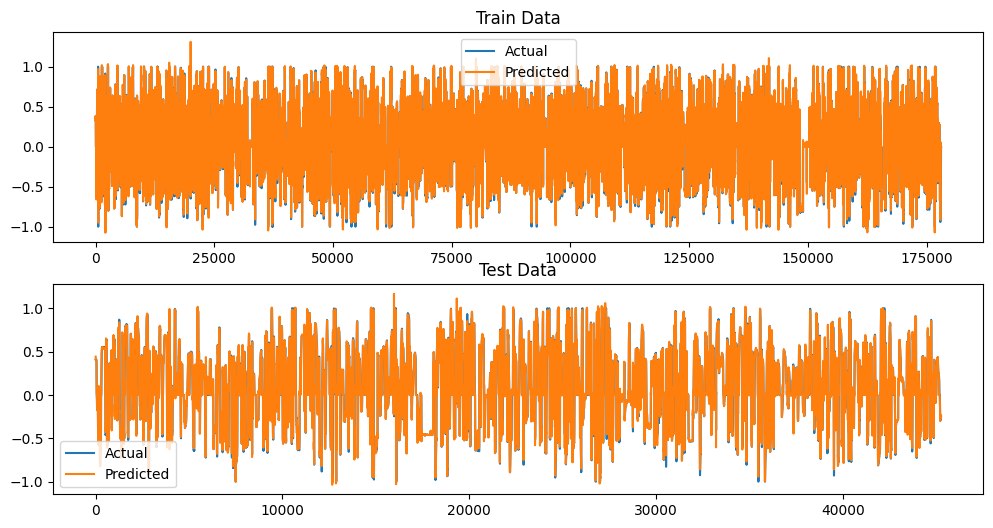

In [24]:
print(f"Train MSE: {a_train_mse}")
print(f"Test MSE: {a_test_mse}")

# Plot the results
plt.figure(figsize=(12, 6)) 
plt.subplot(2, 1, 1)
plt.plot(a_y_train, label='Actual')
plt.plot(a_y_train_pred, label='Predicted')
plt.title('Train Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(a_y_test, label='Actual')
plt.plot(a_y_test_pred, label='Predicted')
plt.title('Test Data')
plt.legend()

plt.show()

#### Inspect Coefficient

In [25]:
coefficients = a_model.coef_.flatten()
feature_names = a_poly.get_feature_names_out()
feature_names

array(['1', 'ApproachRateOther', 'Rel_Pos_Magnitude', 'SteerB',
       'A_Head_Center_Distance', 'B_Head_Center_Distance',
       'Filtered_B_Head_Velocity_Total', 'A_Turn', 'B_Indicator',
       'Centerline_Offset_B', 'RelativeRotation', 'AccelA_lag1',
       'AccelA_lag2', 'AccelA_lag3', 'AccelA_lag4', 'AccelA_lag5',
       'ApproachRateOther^2', 'ApproachRateOther Rel_Pos_Magnitude',
       'ApproachRateOther SteerB',
       'ApproachRateOther A_Head_Center_Distance',
       'ApproachRateOther B_Head_Center_Distance',
       'ApproachRateOther Filtered_B_Head_Velocity_Total',
       'ApproachRateOther A_Turn', 'ApproachRateOther B_Indicator',
       'ApproachRateOther Centerline_Offset_B',
       'ApproachRateOther RelativeRotation',
       'ApproachRateOther AccelA_lag1', 'ApproachRateOther AccelA_lag2',
       'ApproachRateOther AccelA_lag3', 'ApproachRateOther AccelA_lag4',
       'ApproachRateOther AccelA_lag5', 'Rel_Pos_Magnitude^2',
       'Rel_Pos_Magnitude SteerB',
       'R

In [26]:
weights = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])
sorted_weights = weights.sort_values(by='Coefficient', ascending=False)

sorted_weights.iloc[:20,:]

,Coefficient
AccelA_lag1,1.332938
AccelA_lag2 AccelA_lag3,0.227907
AccelA_lag1 AccelA_lag4,0.124553
AccelA_lag1 AccelA_lag2,0.107616
A_Head_Center_Distance AccelA_lag2,0.089080
B_Head_Center_Distance AccelA_lag2,0.054204
AccelA_lag2 AccelA_lag5,0.052129
AccelA_lag3 AccelA_lag5,0.044200
Centerline_Offset_B AccelA_lag1,0.036222
Filtered_B_Head_Velocity_Total AccelA_lag1,0.026152


### Centerline Offset Prediction

In [27]:
# Train and evaluate the Polynomial Regression model
co_degree = 2
co_max_lag = 10

co_model, co_poly, co_y_train_pred, co_y_train, co_train_mse = train_poly_regression(train_data,  InputHeader, OutputHeader[1], co_degree, co_max_lag)
co_y_test_pred, co_y_test, co_test_mse = test_poly_regression(test_data,  InputHeader, OutputHeader[1], co_model, co_poly, scaler, co_max_lag)

Train MSE: 0.006378572135651107
Test MSE: 0.007176312071804878


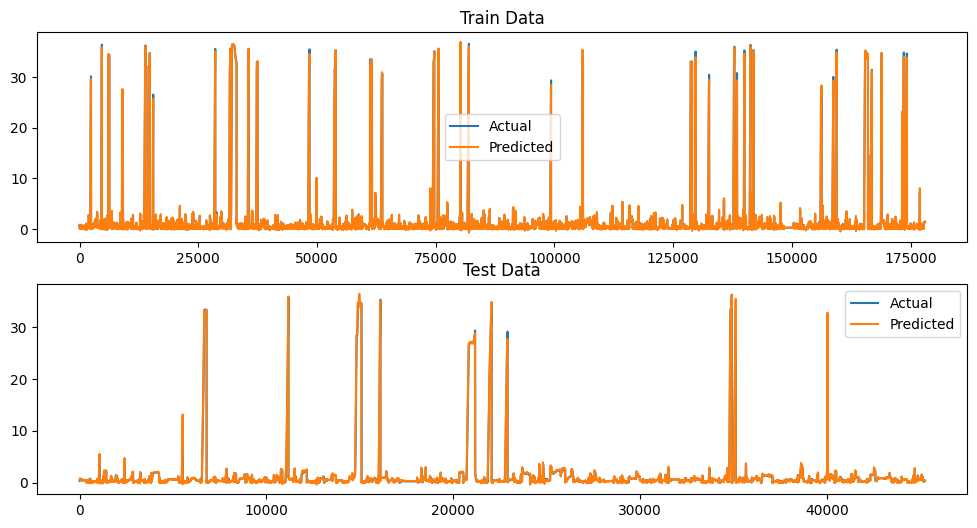

In [28]:
print(f"Train MSE: {co_train_mse}")
print(f"Test MSE: {co_test_mse}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(co_y_train, label='Actual')
plt.plot(co_y_train_pred, label='Predicted')
plt.title('Train Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(co_y_test, label='Actual')
plt.plot(co_y_test_pred, label='Predicted')
plt.title('Test Data')
plt.legend()

plt.show()

#### Inspect Coefficients

In [55]:
coefficients = co_model.coef_.flatten()
feature_names = co_poly.get_feature_names_out()

weights = pd.DataFrame(data=coefficients, index=feature_names, columns=['Coefficient'])
sorted_weights = weights.sort_values(by='Coefficient', ascending=False)

sorted_weights.iloc[:20,:]

,Coefficient
Centerline_Offset_A_lag1,0.967496
Centerline_Offset_A_lag6 Centerline_Offset_A_lag9,0.688245
Centerline_Offset_A_lag3 Centerline_Offset_A_lag9,0.636219
Centerline_Offset_A_lag3 Centerline_Offset_A_lag6,0.592154
Centerline_Offset_A_lag2 Centerline_Offset_A_lag5,0.455517
Centerline_Offset_A_lag5 Centerline_Offset_A_lag8,0.454387
Centerline_Offset_A_lag1 Centerline_Offset_A_lag4,0.386158
Centerline_Offset_A_lag1 Centerline_Offset_A_lag10,0.297016
Centerline_Offset_A_lag5 Centerline_Offset_A_lag10,0.267932
Centerline_Offset_A_lag2 Centerline_Offset_A_lag3,0.256992


### Visualization

In [63]:
def DrawPicture(file, a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag):
    test_data = pd.read_feather(file)
    plt.figure(figsize=(14, 6))
    
    # For AccelA
    a_y_test_pred, a_y_test, a_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)
    
    # For Centerline_Offset_A
    co_y_test_pred, co_y_test, co_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[1], co_model, co_poly, scaler, co_max_lag)

    plt.subplot(1, 2, 1)
    plt.plot(a_y_test, label='Original AccelA', color='b')
    plt.plot(pd.DataFrame(a_y_test_pred).shift(a_max_lag), label='Predicted AccelA', color='r')
    plt.xlabel('Scenario Time')
    plt.ylabel('AccelA')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(co_y_test, label='Original Centerline Offset', color='b')
    plt.plot(pd.DataFrame(co_y_test_pred).shift(co_max_lag), label='Predicted Centerline Offset', color='r')
    plt.xlabel('Scenario Time')
    plt.ylabel('Centerline Offset A')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(file)
    print(f"AccelA Test MSE: {a_test_mse}")
    print(f"Centerline_Offset_A Test MSE: {co_test_mse}")

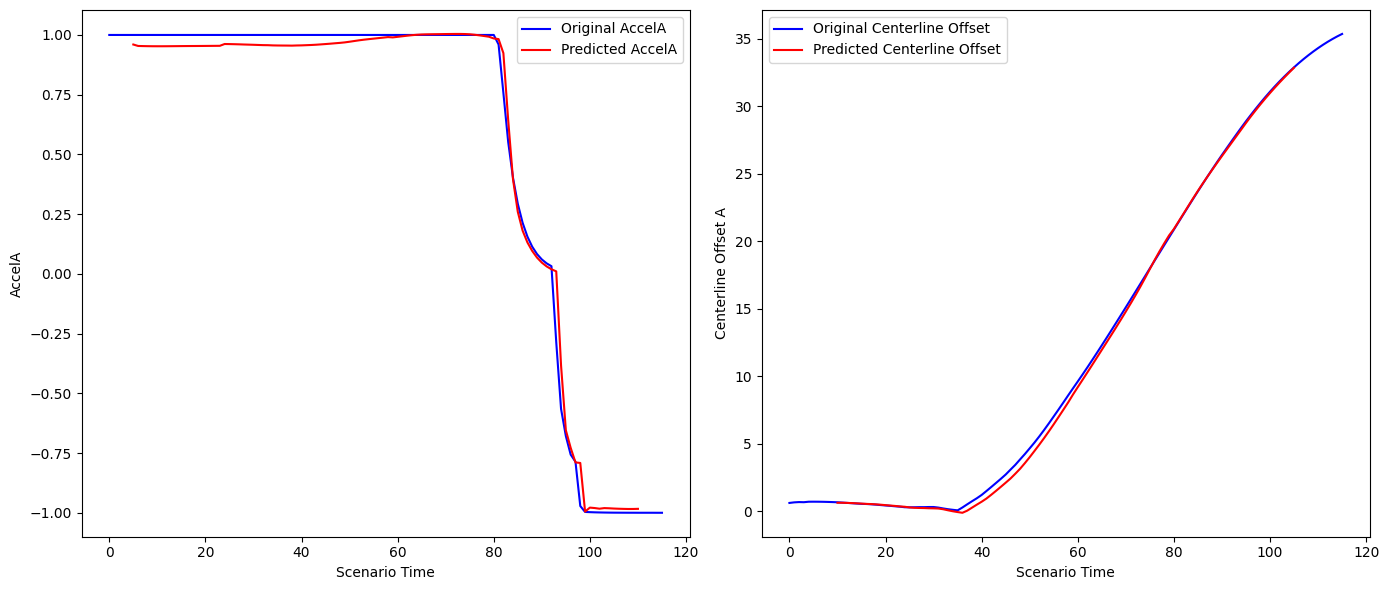

./GeneratedData/CP5_NYC36.feather
AccelA Test MSE: 0.014782375993177423
Centerline_Offset_A Test MSE: 0.0025828630653893106


In [64]:
# Example
DrawPicture('./GeneratedData/CP5_NYC36.feather', a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)

In [65]:
OutDict = {}

for file in test_files:
    test_data = pd.read_feather(file)
    
    # Test and evaluate the model on the test set
    a_y_test_pred, a_y_test, a_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[0], a_model, a_poly, scaler, a_max_lag)
    
    co_y_test_pred, co_y_test, co_test_mse = test_poly_regression(test_data, InputHeader, OutputHeader[1], co_model, co_poly, scaler, co_max_lag)

    # Store the test MSE for each file
    OutDict[file] = [a_test_mse, co_test_mse]

In [66]:
OutDict = dict(sorted(OutDict.items(), key=lambda item: item[1], reverse=True))
# OutDict

----- WORST-----


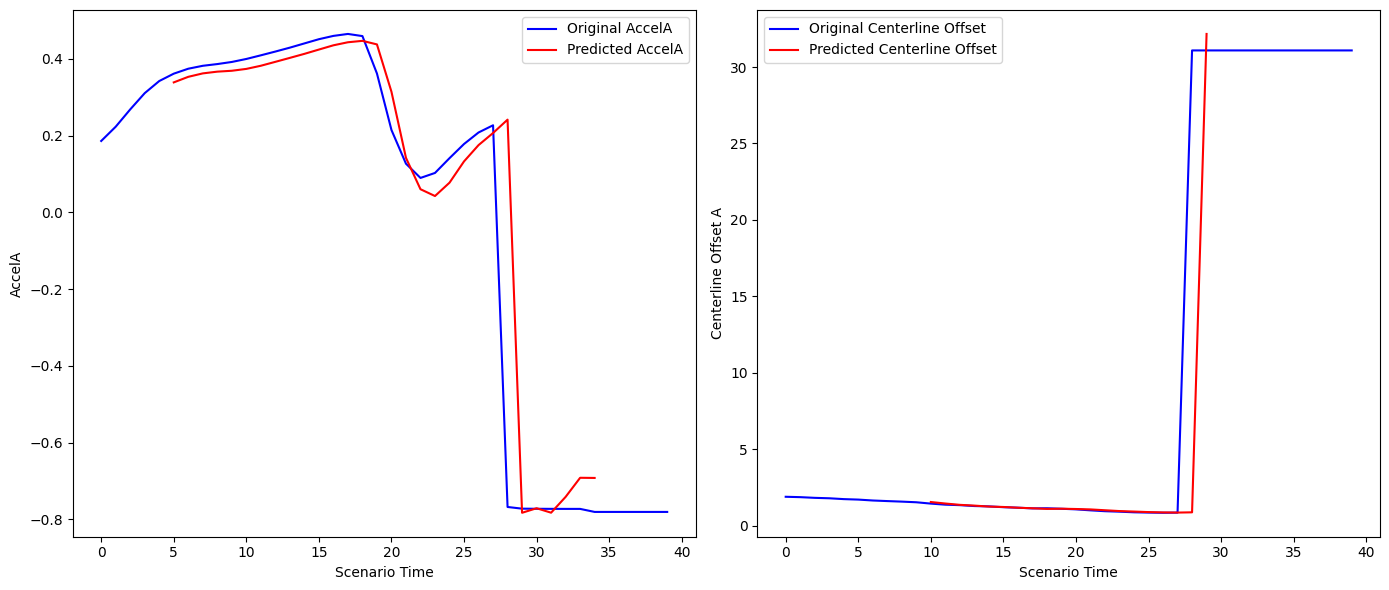

./GeneratedData/CP8_NYC1.feather
AccelA Test MSE: 0.17954738952605773
Centerline_Offset_A Test MSE: 0.85594618066099


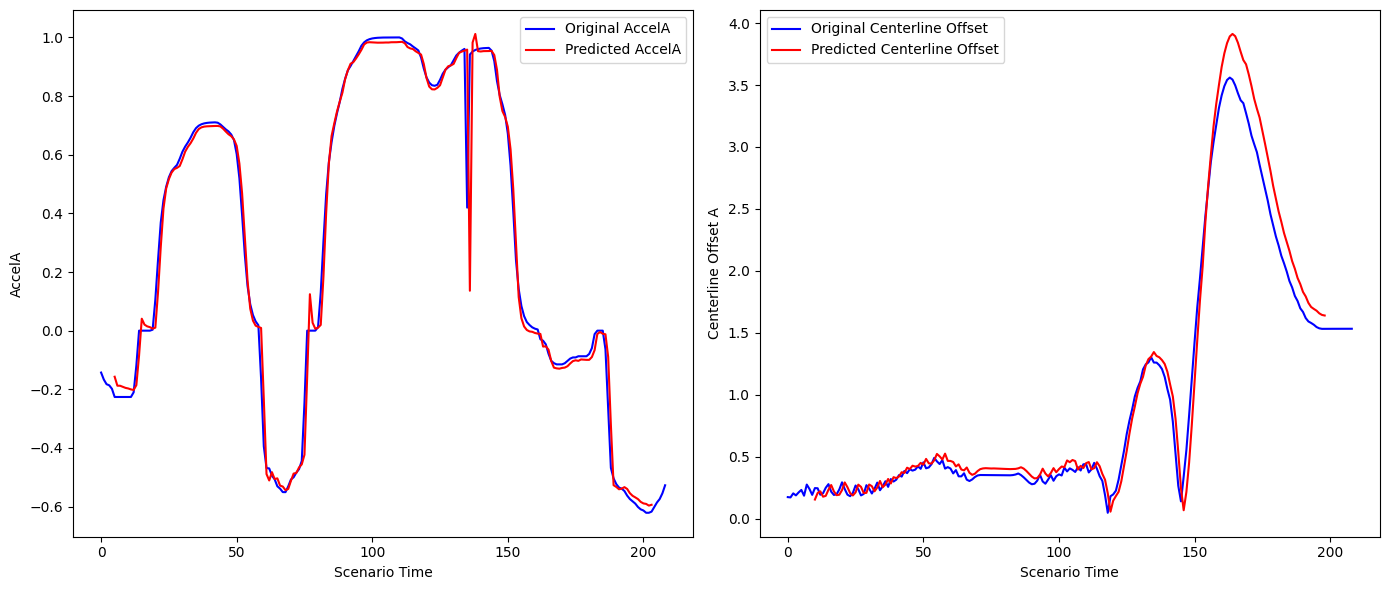

./GeneratedData/CP8_ISR31.feather
AccelA Test MSE: 0.03571813254676107
Centerline_Offset_A Test MSE: 0.00068734981203876


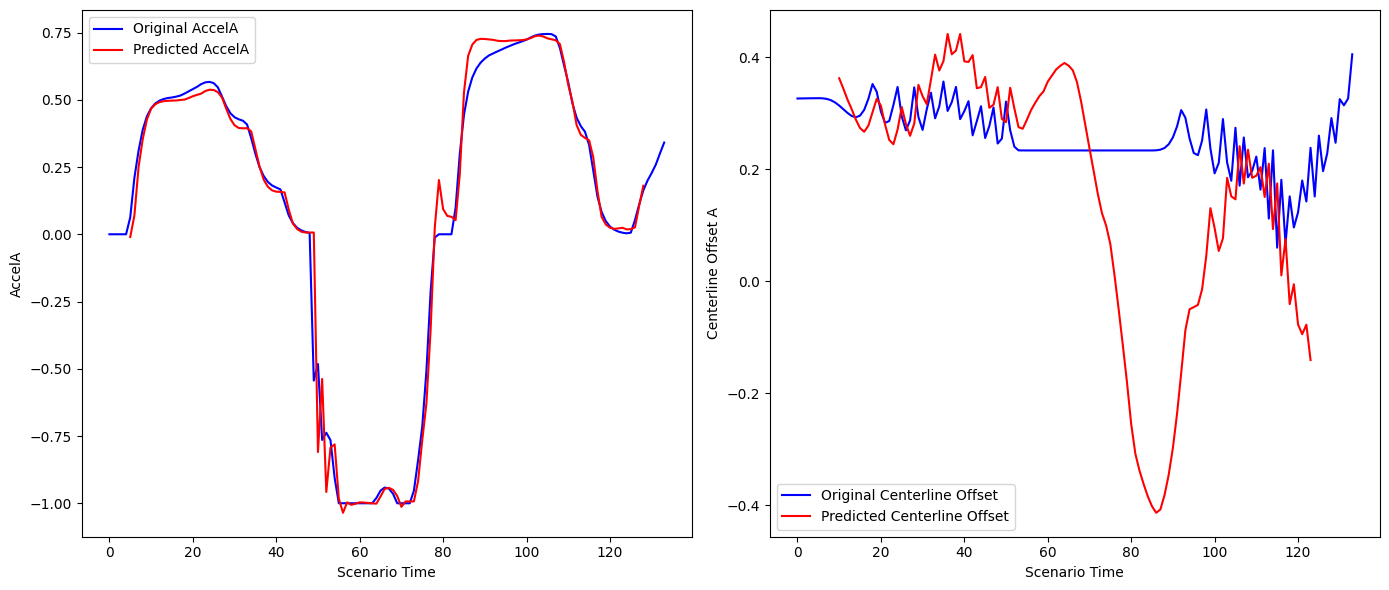

./GeneratedData/CP8_ISR13.feather
AccelA Test MSE: 0.03434618816833624
Centerline_Offset_A Test MSE: 0.0016153972961037118


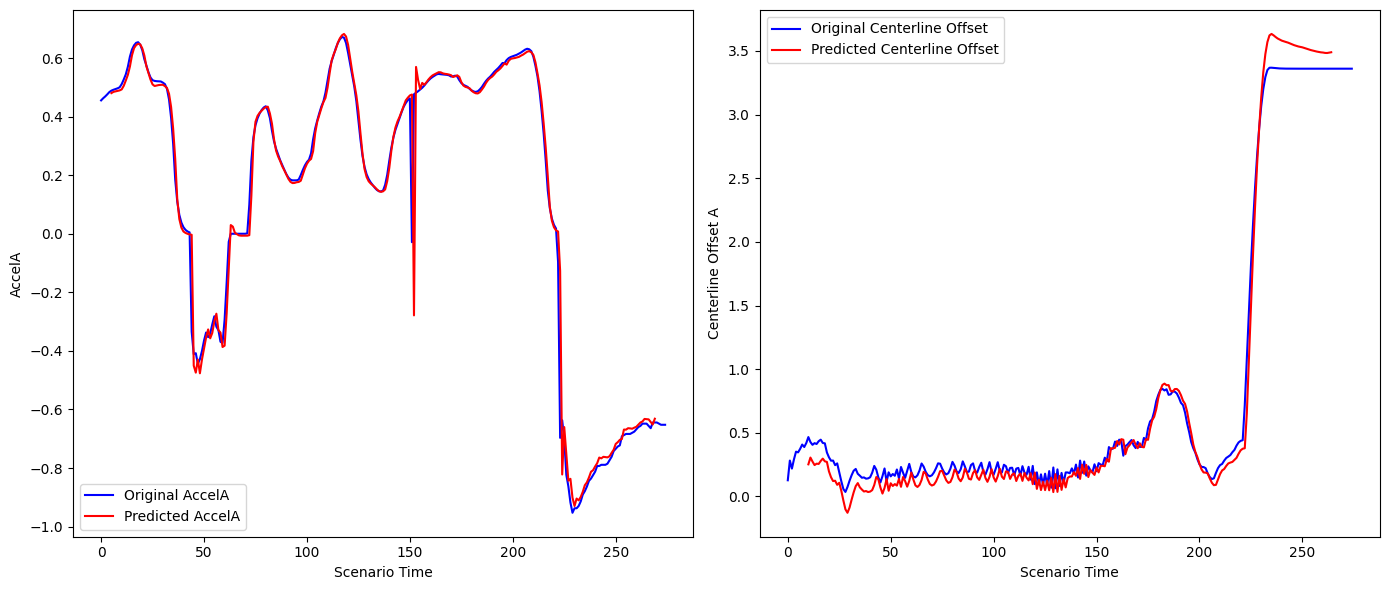

./GeneratedData/CP6_ISR38.feather
AccelA Test MSE: 0.03065849574136992
Centerline_Offset_A Test MSE: 0.0003760848625535464


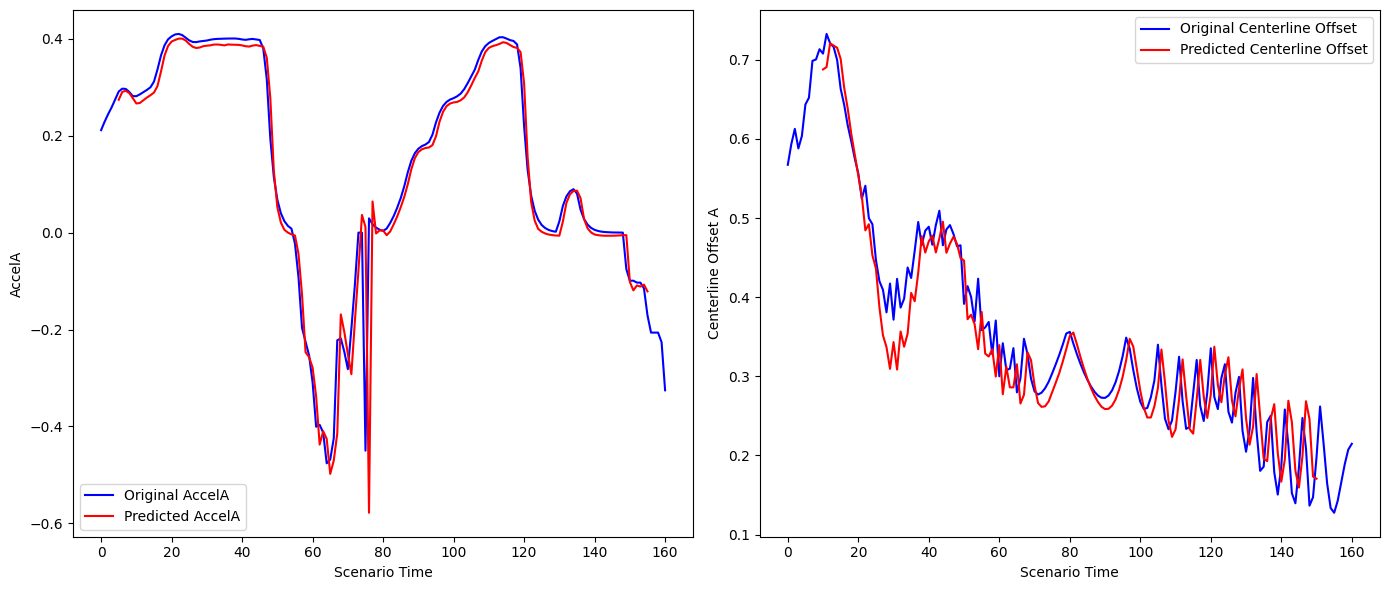

./GeneratedData/CP7_ISR30.feather
AccelA Test MSE: 0.02662558339913489
Centerline_Offset_A Test MSE: 4.747280738795933e-05
----- BEST-----


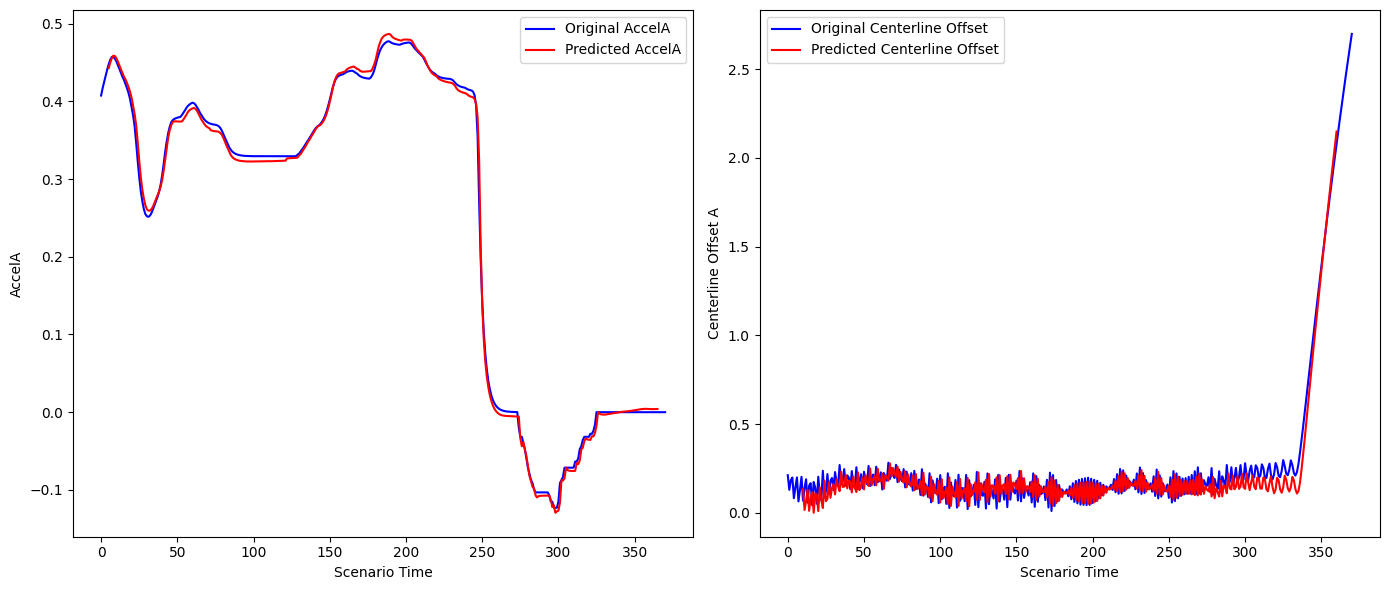

./GeneratedData/CP7_NYC25.feather
AccelA Test MSE: 0.00029414187826905214
Centerline_Offset_A Test MSE: 0.0002599970023406234


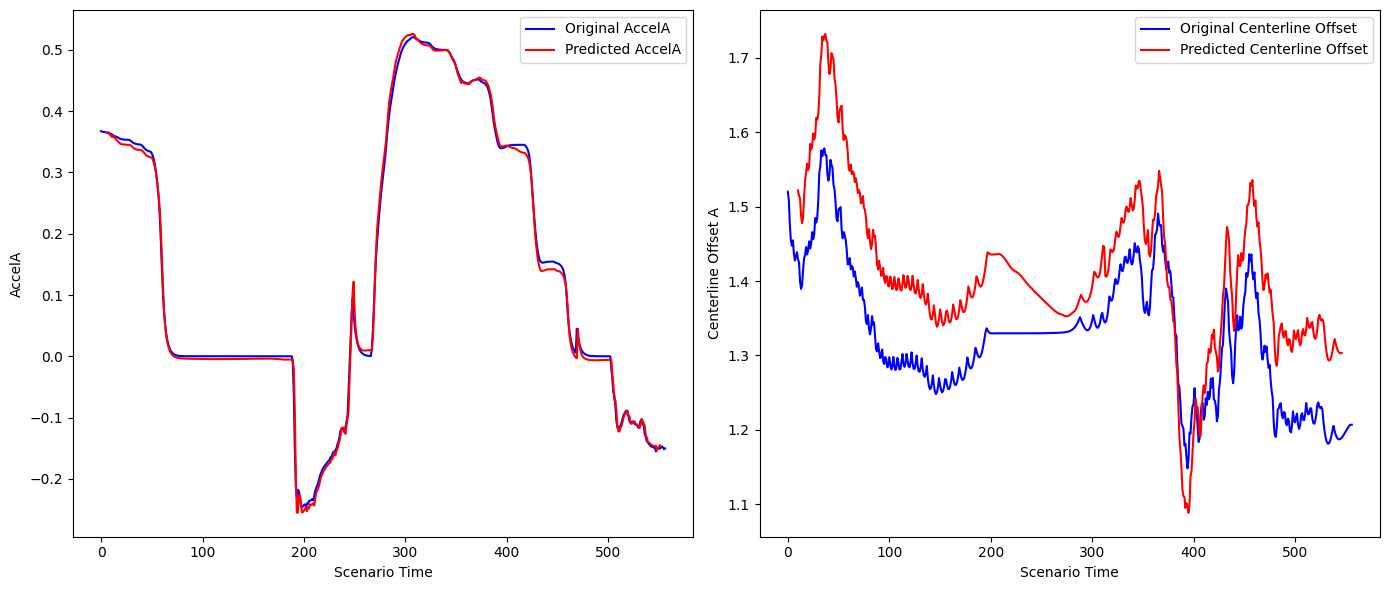

./GeneratedData/CP5_NYC6PARENT.feather
AccelA Test MSE: 0.0004620354505096723
Centerline_Offset_A Test MSE: 0.00024437389961473794


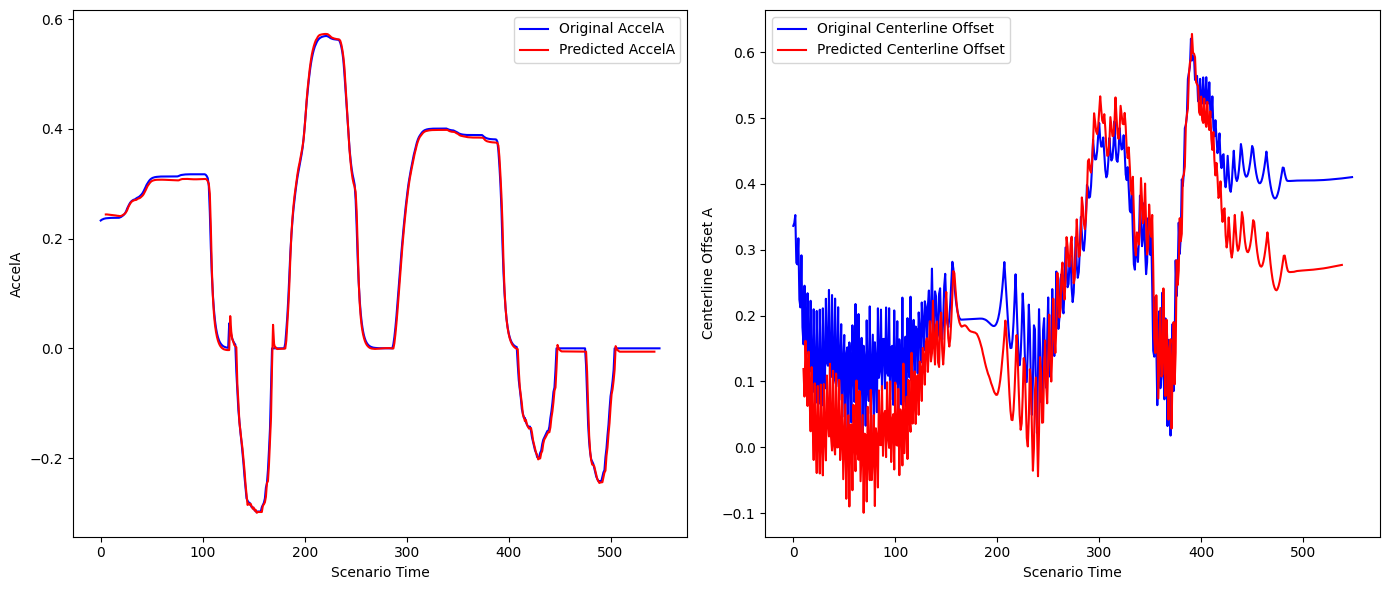

./GeneratedData/CP6_NYC16.feather
AccelA Test MSE: 0.0005047177433218962
Centerline_Offset_A Test MSE: 0.00029255767364244183


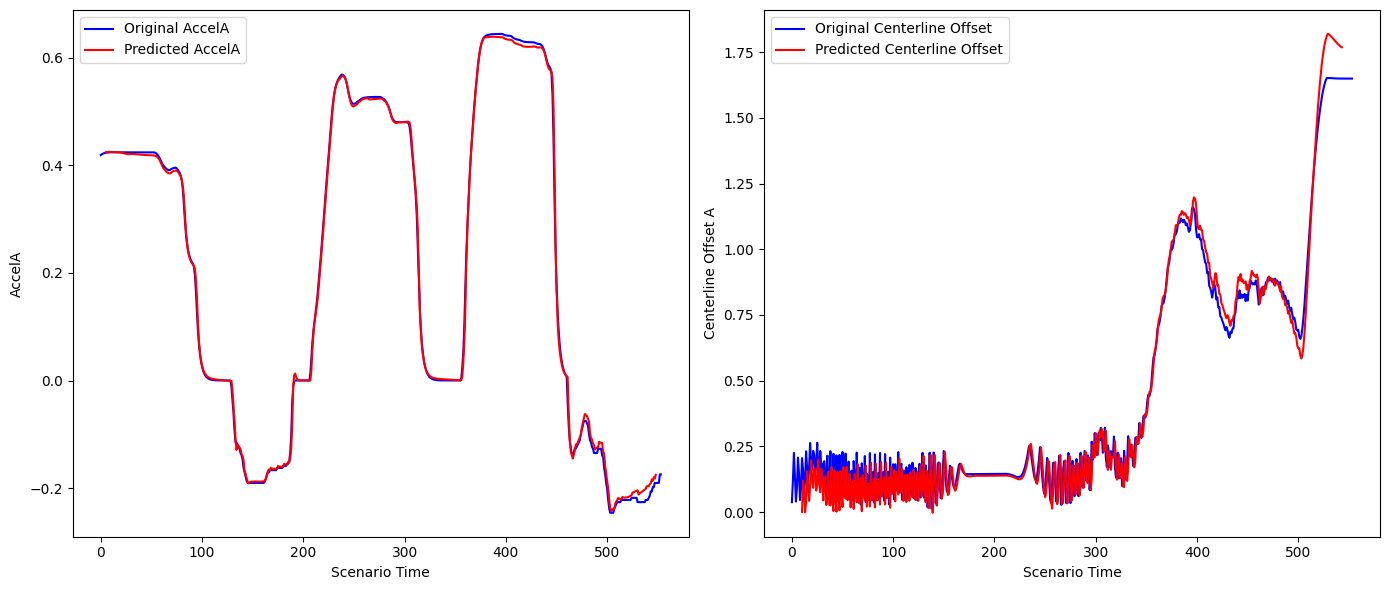

./GeneratedData/CP3_NYC16.feather
AccelA Test MSE: 0.0005183412095007085
Centerline_Offset_A Test MSE: 0.0001635662711268551


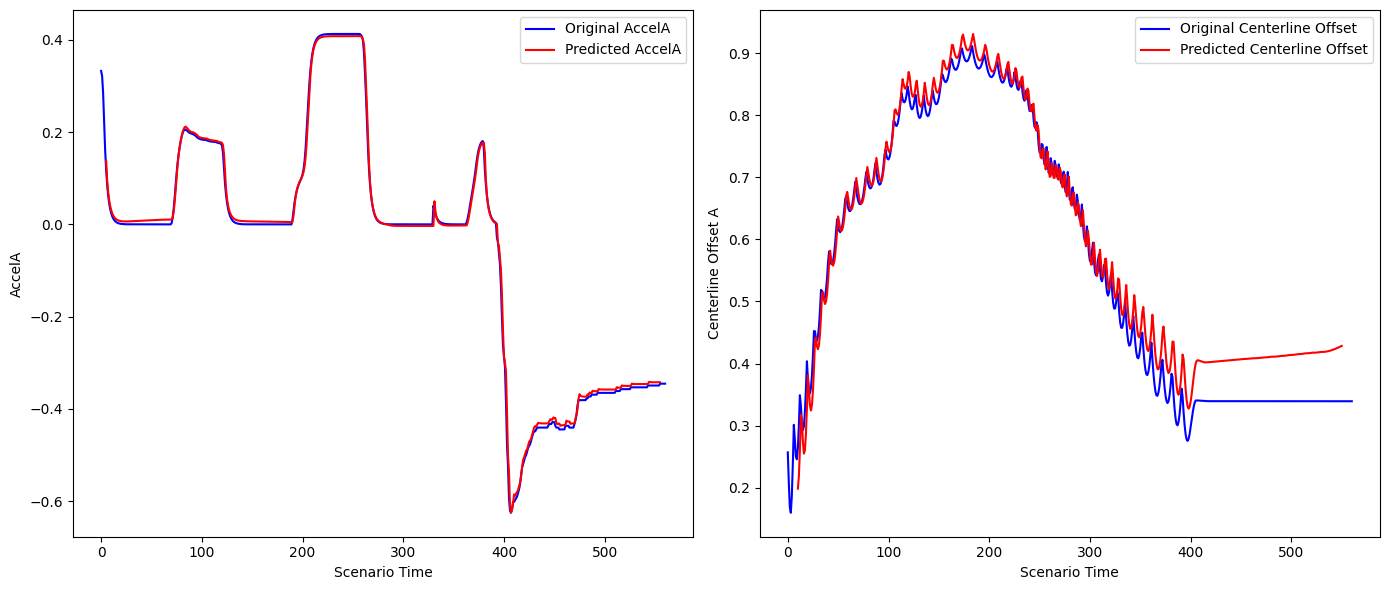

./GeneratedData/CP1_NYC7.feather
AccelA Test MSE: 0.000537584821839551
Centerline_Offset_A Test MSE: 5.949295732813332e-05


In [67]:
print("----- WORST-----")
DrawPicture(list(OutDict.keys())[0], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[1], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[2], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[3], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[4], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
print("----- BEST-----")
DrawPicture(list(OutDict.keys())[-1], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-2], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-3], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-4], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)
DrawPicture(list(OutDict.keys())[-5], a_model, co_model, a_poly, co_poly, a_max_lag, co_max_lag)

### Grid Search

In [ ]:
def grid_search_poly_regression(train_data, test_data, feature_list, target_col, degrees, max_lags):
    results = []
    for degree, max_lag in product(degrees, max_lags):
        # Train the model
        model, poly, y_train_pred, y_train, train_mse = train_poly_regression(train_data, feature_list, target_col, degree, max_lag)
        
        # Evaluate the model
        y_test_pred, y_test, test_mse = test_poly_regression(test_data, feature_list, target_col, model, poly, scaler, max_lag)
        
        # Collect results
        results.append({
            'degree': degree,
            'max_lag': max_lag,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'model': model,
            'poly': poly
        })
        print(f"Degree: {degree}, Max Lag: {max_lag}, Train MSE: {train_mse}, Test MSE: {test_mse}")

    # Find best model based on test MSE
    best_result = min(results, key=lambda x: x['test_mse'])
    return best_result, results

In [ ]:
# Parameters to search
degrees = [2]
max_lags = [9, 10, 11, 12, 13, 14]

In [ ]:
# Grid search for AccelA
print("Starting grid search for AccelA...")
best_result_AccelA, results_AccelA = grid_search_poly_regression(train_data, test_data, InputHeader, 'AccelA', degrees, max_lags)
print(f"Best configuration for AccelA: Degree {best_result_AccelA['degree']}, Max Lag {best_result_AccelA['max_lag']} with Test MSE {best_result_AccelA['test_mse']}")

Starting grid search for AccelA...
Degree: 2, Max Lag: 9, Train MSE: 0.014418549682223879, Test MSE: 0.0004644676850309737
Degree: 2, Max Lag: 10, Train MSE: 0.014412053758796757, Test MSE: 0.0004628571546762608
Degree: 2, Max Lag: 11, Train MSE: 0.01440777009616498, Test MSE: 0.00046480279685043703
Degree: 2, Max Lag: 12, Train MSE: 0.014403595364936364, Test MSE: 0.00046732784185182514
Degree: 2, Max Lag: 13, Train MSE: 0.014397073983612315, Test MSE: 0.00046776261323696645
Degree: 2, Max Lag: 14, Train MSE: 0.014391188714366666, Test MSE: 0.0004672275840651991
Best configuration for AccelA: Degree 2, Max Lag 10 with Test MSE 0.0004628571546762608


In [ ]:
# Grid search for Centerline_Offset_A
print("Starting grid search for Centerline_Offset_A...")
best_result_Centerline, results_Centerline = grid_search_poly_regression(train_data, test_data, InputHeader, 'Centerline_Offset_A', degrees, max_lags)
print(f"Best configuration for Centerline_Offset_A: Degree {best_result_Centerline['degree']}, Max Lag {best_result_Centerline['max_lag']} with Test MSE {best_result_Centerline['test_mse']}")

Starting grid search for Centerline_Offset_A...
Degree: 2, Max Lag: 9, Train MSE: 0.006379542705503266, Test MSE: 0.007177057691621126
Degree: 2, Max Lag: 10, Train MSE: 0.006378572135651107, Test MSE: 0.007176312071804878
Degree: 2, Max Lag: 11, Train MSE: 0.0063775710907779766, Test MSE: 0.00717605469968966
Degree: 2, Max Lag: 12, Train MSE: 0.006376728277481425, Test MSE: 0.007176842970139618
Degree: 2, Max Lag: 13, Train MSE: 0.006376012245790589, Test MSE: 0.007209099257788584
Degree: 2, Max Lag: 14, Train MSE: 0.006375266658401583, Test MSE: 0.00721575819716601
Best configuration for Centerline_Offset_A: Degree 2, Max Lag 11 with Test MSE 0.00717605469968966
